# Análisis para tienda de alimentos
## Objetivo:
Estudiar el comportamiento de los usuarios para la aplicación de la empresa.

### Objetivos específicos:
* Análisis exploratorio:
  * Número de eventos y usuarios en los registros
  * Promedio de eventos por usuario
  * Periodo de los datos
  * Confirmación de 3 grupos experimentales

* Análisis de embudo:
  * Elaborar el embudo
  * Proporción de usuarios por cada evento
  * Proporción de usuarios que pasan a la siguiente etapa
  * Evaluar las etapas
  * Cantidad de usuarios que completan el viaje (primer evento hasta pago)

* Análisis de experimento A/A/B:
  * Número de usuarios por grupo
  * Evaluar diferencia entre grupos control (A/A)
  * Evaluar diferencia entre eventos para los grupos control
  * Comparar diferencia de grupos control con grupo con variante

## Diccionario de datos:
* ``EventName``: nombre del evento.
* ``DeviceIDHash``: identificador de usuario unívoco.
* ``EventTimestamp``: hora del evento.
* ``ExpId``: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

In [1]:
# importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importar datasets
events = pd.read_csv('logs_exp_us.csv', sep='\t')

# Visualización general de los datos

In [3]:
# información general de 'logs_exp_us'
events.info()
print('\n', 'Hay', events.duplicated().sum(), 'valores duplicados')
print('\n', events.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

 Hay 413 valores duplicados

                  EventName         DeviceIDHash  EventTimestamp  ExpId
97393   OffersScreenAppear  1379176160808388540      1564845355    246
35124   OffersScreenAppear  2024274277554107641      1564686233    248
40371     MainScreenAppear  1694940645335807244      1564710625    248
150853    MainScreenAppear  5141538748160044717      1564998322    247
239329    MainScreenAppear  8623766686511551630      1565199599    246


### Comentario:
En el dataset no hay valores ausentes. Sin embargo, hay valores duplicados, por lo que se tiene que revisar estos valores, determinar su posible explicación y definir cómo deben de ser tratados. Por otro lado, hay que modificar el nombre de las columnas y en el caso de "EventTimestamp" los valores se encuentran en segundos por lo que hay que convertirlo a un tipo que se maneje con mayor facilidad y asignar una columna para guardar exclusivamente la fecha del evento.

Además puede resultar conveniente definir el tipo de datos para las columnas "DeviceIDHash" y "ExpId" ya que al ser variables categóricas pueden ser manejadas como `strings`.

# Limpieza de datos

In [4]:
# definir nombres de columnas
events.columns = ['event_name', 'uid', 'dt', 'group']

In [5]:
# convertir a strings
events['uid'] = events['uid'].astype('str')
events['group'] = events['group'].astype('str')

# convertir a datetime
events['dt'] = pd.to_datetime(events['dt'], unit='s')

In [6]:
# agregar columna de fecha
events ['date'] = events['dt'].dt.date
events['date'] = pd.to_datetime(events['date'])

In [7]:
# revisar duplicados
duplicates = events[events.duplicated()]

print(duplicates)

# borrar duplicados
events.drop_duplicates(inplace=True)

print('\n', 'Registros post-limpieza:', events.shape)

                     event_name                  uid                  dt  \
453            MainScreenAppear  5613408041324010552 2019-07-30 08:19:44   
2350           CartScreenAppear  1694940645335807244 2019-07-31 21:51:39   
3573           MainScreenAppear   434103746454591587 2019-08-01 02:59:37   
4076           MainScreenAppear  3761373764179762633 2019-08-01 03:47:46   
4803           MainScreenAppear  2835328739789306622 2019-08-01 04:44:01   
...                         ...                  ...                 ...   
242329         MainScreenAppear  8870358373313968633 2019-08-07 19:26:44   
242332  PaymentScreenSuccessful  4718002964983105693 2019-08-07 19:26:45   
242360  PaymentScreenSuccessful  2382591782303281935 2019-08-07 19:27:29   
242362         CartScreenAppear  2382591782303281935 2019-08-07 19:27:29   
242635         MainScreenAppear  4097782667445790512 2019-08-07 19:36:58   

       group       date  
453      248 2019-07-30  
2350     248 2019-07-31  
3573     

### Comentario 
Los valores duplicados muestran la probabilidad de que los sistemas de registro de eventos pueden estar fallando y estarse duplicando los registros, sugiero que estos puedan ser revisados y de ser posible se revise las condiciones que se deben cumplir para asegurar el correcto funcionamiento. Los valores duplicados serán borrados.

# Análisis exploratorio

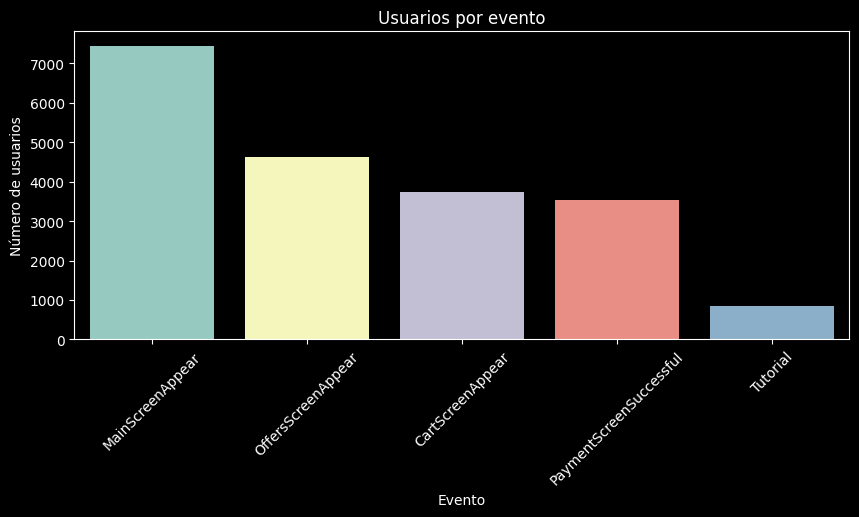

Número total de usuarios: 7551


In [8]:
# número de usuarios por evento
# dataframe de usuarios por evento
users_per_event = events.groupby('event_name', as_index=False)['uid'].nunique()

# gráfico de barras: usuarios por evento
plt.style.use('dark_background')
plt.figure(figsize=(10,4))
sns.barplot(users_per_event.sort_values(by='uid', ascending=False),
            x='event_name',
            y='uid',
            hue='event_name')
plt.title('Usuarios por evento')
plt.xlabel('Evento')
plt.ylabel('Número de usuarios')
plt.xticks(rotation=45)
plt.show()

# número total de usuarios
print('Número total de usuarios:', events['uid'].nunique())

In [9]:
# número de eventos por usuario
event_per_users = events.groupby('uid', as_index=False)['event_name'].nunique()

# promedio de eventos por usuario
print('Promedio de eventos por usuario:', event_per_users['event_name'].mean())

Promedio de eventos por usuario: 2.6744802012978415


Fecha inicial: 2019-07-25 00:00:00
Fecha final: 2019-08-07 00:00:00


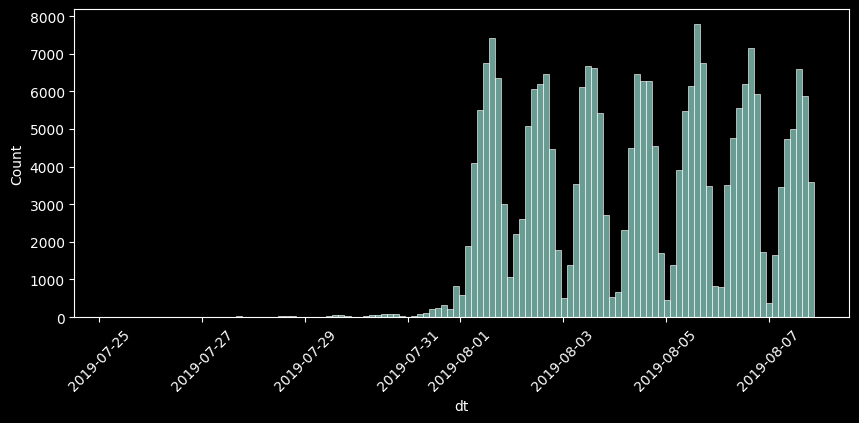

In [10]:
# visualización de periodo
print('Fecha inicial:', events['date'].min())
print('Fecha final:', events['date'].max())

# histograma: distribución en fecha y hora
plt.figure(figsize=(10,4))
sns.histplot(events['dt'])
plt.xticks(rotation=45)
plt.show()

In [11]:
# filtrado de periodo relevante para el experimento
experiment_period = events[events['date'] >= '2019-08-01']

print('\n', 'Registros post-filtrado:', experiment_period.shape)
print('Número total de usuarios:', experiment_period['uid'].nunique())


 Registros post-filtrado: (240887, 5)
Número total de usuarios: 7534


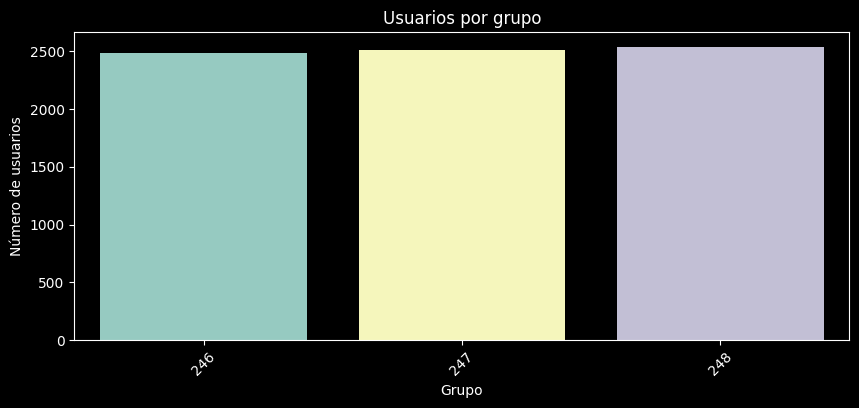

In [12]:
# número de usuarios en cada grupo
users_per_group = experiment_period.groupby('group', as_index=False)['uid'].nunique()

# gráfico de barras: número de usuarios en cada grupo
plt.figure(figsize=(10,4))
sns.barplot(users_per_group,
            x='group',
            y='uid',
            hue='group')
plt.title('Usuarios por grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de usuarios')
plt.xticks(rotation=45)
plt.show()

In [13]:
# lista de usuarios
users_group_246 = experiment_period[experiment_period['group'] == 246]['uid'].unique()
users_group_247 = experiment_period[experiment_period['group'] == 247]['uid'].unique()
users_group_248 = experiment_period[experiment_period['group'] == 248]['uid'].unique()

# usuarios en común en los grupos
common_users = np.intersect1d(
    np.intersect1d(users_group_246, users_group_247),
    users_group_248)
print('Usuarios repetidos en grupos:', len(common_users))

Usuarios repetidos en grupos: 0


### Comentario:
De manera general, el periodo de los registros abarca de 2019/07/25 - 2019/08/07 en donde se registran 5 eventos, de los cuales en promedio los usuarios realizan 2. Se puede observar que tanto "CartScreen" como "PaymentScreen" tienen casi la misma cantidad de usuarios, esto apunta a que los usuarios que agregan productos al carrito efectúan la compra. El evento "tutorial" es realizado por menos de 1,000 usuarios. 

Al visualizar la distribución de los registros, se puede notar que antes del 2019/08/01 prácticamente no había registros de usuarios, por lo que el periodo a partir del 1° de agosto será el que se considere para analizar los resultados, entre estos periodos hay una diferencia de 17 usuarios, por lo que la segmentación del periodo no resulta perjudicial para el análisis.

Finalmente, se puede apreciar que los 3 grupos experimentales se encuentran prácticamente equilibrados en el número de usuarios que contienen, de los cuales no hay usuarios repetidos entre ellos.